### Supervisor Multi Agent


In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_groq import ChatGroq

In [2]:
## Load LLM model
model = 'qwen/qwen3-32b'
llm = ChatGroq(model=model)

In [3]:
llm.invoke("What is the capital of France").content

'<think>\nOkay, so the user is asking "What is the capital of France?" Let me think. I know that France is a country in Europe, and capitals are usually the main cities where the government is located. The most famous cities in France include Paris, Lyon, Marseille, and maybe Bordeaux? But which one is the capital?\n\nI remember from school that Paris is the capital. Wait, is there any chance it\'s another city? Maybe I should double-check. Let me recall some other facts. Paris is known for the Eiffel Tower, the Louvre, and being a cultural hub. Yes, that\'s right. Also, the French government is based in Paris, with institutions like the Élysée Palace where the president works. \n\nI think I\'ve heard before that sometimes people confuse Lyon or Marseille as the capital, but no, those are major cities but not capitals. Let me confirm another way. If I think about the country\'s map, France is in Western Europe, bordered by countries like Belgium, Spain, Germany. The capital should be i

In [4]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_tool = TavilySearchResults(max_result =3)

In [5]:
code = '''
x=10
y=x+10
print(y)
'''

In [6]:
from langchain_experimental.utilities import PythonREPL
repl = PythonREPL()

In [7]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'20\n'

In [8]:
from typing import Annotated
from langchain_core.tools import tool

In [9]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str 

<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
C:\Users\ashut\AppData\Local\Temp\ipykernel_27132\1154733478.py:11: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\ashut\AppData\Local\Temp\ipykernel_27132\1154733478.py:11: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [10]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x=10
y=x+10
print(y)

\`\`\`
Stdout: 20



In [11]:
## we will define the member agents of our architecture
members = ["researcher","coder"]

In [12]:
options = members+["FINISH"]
options

['researcher', 'coder', 'FINISH']

In [13]:
from typing import TypedDict, Literal

class Router(TypedDict): 
    next: Literal['researcher', 'coder', 'FINISH']

In [14]:
from langgraph.graph import MessagesState, StateGraph, START, END

In [15]:
class State(MessagesState):
    next: str

In [16]:
system_prompt = f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [37]:
system_prompt = f"""
You are a supervisor managing a task delegation system with the following workers: {members}.

Your job is to decide which worker should act next based on the user’s input.

Guidelines:
- Carefully read the user’s message.
- If the message clearly requires a specific action (e.g., search, compute, rewrite), assign it to the appropriate worker.
- If the message is general, conversational, or does **not** require any specific action, immediately respond with `FINISH`.
- Do **not** invent tasks or assign actions unless the message clearly demands it.

Each worker will return results after completing their task.
Once all necessary tasks are completed, end the flow by responding with `FINISH`.

Be strict — if the message is casual, rhetorical, or lacks a clear task, reply with `FINISH`.
"""



In [38]:
print(system_prompt)


You are a supervisor managing a task delegation system with the following workers: ['researcher', 'coder'].

Your job is to decide which worker should act next based on the user’s input.

Guidelines:
- Carefully read the user’s message.
- If the message clearly requires a specific action (e.g., search, compute, rewrite), assign it to the appropriate worker.
- If the message is general, conversational, or does **not** require any specific action, immediately respond with `FINISH`.
- Do **not** invent tasks or assign actions unless the message clearly demands it.

Each worker will return results after completing their task.
Once all necessary tasks are completed, end the flow by responding with `FINISH`.

Be strict — if the message is casual, rhetorical, or lacks a clear task, reply with `FINISH`.



Now we will define our agents

In [39]:
from langgraph.types import Command
def supervisor_agent(state:State)-> Command[Literal['researcher', 'coder', '__end__']]:
    print('<-- Supervisor -->')
    
    messages = [{'role':'system', 'content': system_prompt},]+state['messages']
    
    llm_with_structured_output = llm.with_structured_output(Router)
    response = llm_with_structured_output.invoke(messages)
    
    ## this is my next worker agent
    goto = response['next']
    
    print("*********Below is my GOTO*****************")
    
    print(goto)
    
    if goto=='FINISH':
        goto = END
    return Command(goto=goto, update={'next':goto})

In [40]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

def researcher_agent(state:State)->Command[Literal['supervisor']]:
    print('<-- Researcher -->')
    
    research_agent = create_react_agent(llm, tools=[tavily_tool], prompt='You are a researcher. DO NOT do any math.')
    
    result = research_agent.invoke(state)
    return Command(
        update={
            'messages':[HumanMessage(content=result['messages'][-1].content, name='researcher')]
        },
        goto='supervisor'
    )

In [41]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    print('<-- Coder -->')
    coder_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt='You are a coder. DO NOT do any research. '
    )
    
    result = coder_agent.invoke(state)
    return Command(
        update ={'messages':[HumanMessage(content=result['messages'][-1].content, name='coder')]},
        goto='supervisor',
    )

In [42]:
## Build Graph
from token import STAR


builder = StateGraph(State)
builder.add_node('supervisor',supervisor_agent)
builder.add_node('researcher',researcher_agent)
builder.add_node('coder',coder_agent)

## Logic
builder.add_edge(START,'supervisor')

## Compile
app = builder.compile()

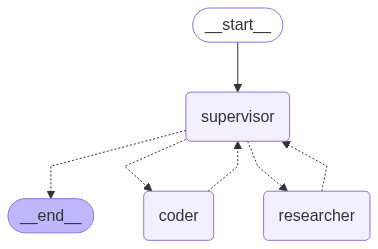

In [29]:
app

In [44]:
for s in app.stream({"messages": [HumanMessage(content="Hi")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")



<-- Supervisor -->
*********Below is my GOTO*****************
FINISH
((), {'supervisor': {'next': '__end__'}})
**********BELOW IS MY STATE***************


In [45]:
for s in app.stream({"messages": [HumanMessage(content="What is an efficient python code to get prime number")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")


<-- Supervisor -->
*********Below is my GOTO*****************
coder
((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************
<-- Coder -->
(('coder:91a4edb4-b5a7-6b48-5e95-53b895e2f793',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'h9m26ar3g', 'function': {'arguments': '{"code":"def sieve_of_eratosthenes(limit):\\n    sieve = [True] * (limit + 1)\\n    sieve[0:2] = [False, False]\\n    for current in range(2, int(limit**0.5) + 1):\\n        if sieve[current]:\\n            for multiple in range(current*current, limit + 1, current):\\n                sieve[multiple] = False\\n    return [num for num, is_prime in enumerate(sieve) if is_prime]\\n\\nprint(sieve_of_eratosthenes(50))"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 1359, 'prompt_tokens': 173, 'total_tokens': 1532, 'completion_time': 2.497363457, 'prompt_time': 0.010912481, 'queue_time': 0.0599